In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(
  '/content/Retail_Transactions_Dataset.csv'
)

In [ ]:
df.head(2)

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,21/01/22 6:27,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,01/03/23 13:01,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)


In [ ]:
df.isna().sum()

,0
Transaction_ID,0
Date,0
Customer_Name,0
Product,0
Total_Items,0
Total_Cost,0
Payment_Method,0
City,0
Store_Type,0
Discount_Applied,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

In [ ]:
df['Discount_Applied'] = df['Discount_Applied'].astype(int)

In [ ]:
df['Total_Items'] = pd.to_numeric(df['Total_Items'], errors='coerce')
df['Total_Cost'] = pd.to_numeric(df['Total_Cost'], errors='coerce')

In [ ]:
df['Promotion'] = df['Promotion'].fillna('None')

In [ ]:
df.isna().sum()

,0
Transaction_ID,0
Date,0
Customer_Name,0
Product,0
Total_Items,0
Total_Cost,0
Payment_Method,0
City,0
Store_Type,0
Discount_Applied,0


In [ ]:
categorical_column = ['Payment_Method','Store_Type','Customer_Category','Season','Promotion']
for col in categorical_column:
  df[col] = df[col].str.strip().str.title()

In [ ]:
df.head(2)

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:00,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,1,Homemaker,Winter,None
1,1000000001,2023-01-03 13:01:00,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,1,Professional,Fall,Bogo (Buy One Get One)


RFM Analysis (Recency, Frequency, Monetary).   
Purpose

To group customers based on how recently, frequently, and monetarily they purchase — helping identify:

- Loyal Customers
- At-Risk Customers
- High-Value Shoppers
- Lost Customers

In [ ]:
from datetime import datetime

In [ ]:
df.columns

Index(['Transaction_ID', 'Date', 'Customer_Name', 'Product', 'Total_Items',
       'Total_Cost', 'Payment_Method', 'City', 'Store_Type',
       'Discount_Applied', 'Customer_Category', 'Season', 'Promotion'],
      dtype='object')

In [ ]:
snapshot_date = df['Date'].max() + pd.Timedelta(days=1)

In [ ]:
rfm = df.groupby('Customer_Name').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'Transaction_ID': 'count',
    'Total_Cost': 'sum'
}).reset_index()

In [ ]:
rfm.columns = ['Customer_Name', 'Recency', 'Frequency', 'Monetary']

In [ ]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

In [ ]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [ ]:
# def segment_customer(rfm):
#     if rfm['R_Score'] in ['4','5'] and rfm['F_Score'] in ['4','5'] and rfm['M_Score'] in ['4','5']:
#         return 'Champion'
#     elif rfm['R_Score'] in ['3','4','5'] and rfm['F_Score'] in ['2','3'] and rfm['M_Score'] in ['3','4','5']:
#         return 'Loyal Customer'
#     elif rfm['R_Score'] in ['4','5'] and rfm['F_Score'] in ['1','2']:
#         return 'New Customer'
#     elif rfm['R_Score'] in ['2','3'] and rfm['F_Score'] in ['2','3'] and rfm['M_Score'] in ['2','3']:
#         return 'Potential Loyalist'
#     elif rfm['R_Score'] in ['1','2'] and rfm['F_Score'] in ['1','2']:
#         return 'Lost Customer'
#     else:
#         return 'Others'

def segment_customer(rfm):
    r = int(rfm['R_Score'])
    f = int(rfm['F_Score'])
    m = int(rfm['M_Score'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champion'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customer'
    elif r >= 4 and f <= 2:
        return 'New Customer'
    elif r <= 2 and f <= 2:
        return 'Lost Customer'
    else:
        return 'Potential Loyalist'


In [ ]:
rfm['Segment'] = rfm.apply(segment_customer, axis = 1)

In [ ]:
rfm.head()

,Customer_Name,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,Aaron Acevedo,363,4,279.85,4,5,5,455,Champion
1,Aaron Acosta,1038,3,215.32,2,4,5,245,Potential Loyalist
2,Aaron Adams,235,12,772.36,5,5,5,555,Champion
3,Aaron Adkins,595,3,118.52,3,4,4,344,Loyal Customer
4,Aaron Aguilar,258,5,236.76,5,5,5,555,Champion


In [ ]:
rfm['Segment'].value_counts()

,count
Segment,
Potential Loyalist,101420
Lost Customer,76617
Champion,74798
Loyal Customer,46764
New Customer,30139


In [ ]:
rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','sum','count']
}).round(2)

Recency Frequency Monetary                     
                       mean      mean     mean          sum   count
Segment                                                            
Champion             310.96      8.15   433.13  32397561.58   74798
Lost Customer       1333.70      1.00    52.44   4017613.14   76617
Loyal Customer       592.82      2.77   151.63   7091055.19   46764
New Customer         367.19      1.00    52.22   1573978.89   30139
Potential Loyalist   957.63      1.52    72.72   7375011.60  101420

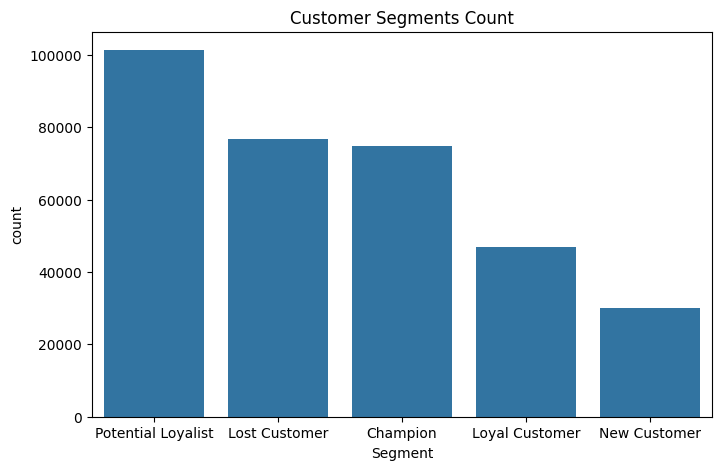

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Count')
plt.show()


Now that you’ve segmented your customers, you can tie each group to specific marketing strategies to maximize ROI:

1. Champions

Who they are: Top spenders, frequent shoppers, recent buyers.

Action: Reward them with VIP programs, early access to new products, exclusive discounts.

Goal: Retain high-value customers and encourage advocacy.

2. Loyal Customers

Who they are: Consistent buyers, moderate spenders.

Action: Keep them engaged with personalized offers, loyalty points, and newsletters.

Goal: Strengthen the relationship to convert them into Champions.

3. At-Risk / Lost Customers

Who they are: Haven’t purchased in a while, low engagement.

Action: Send reactivation campaigns, win-back emails, or special discounts.

Goal: Recover churned customers before they disappear completely.

4. New Customers

Who they are: Recent first-time buyers.

Action: Onboarding emails, product recommendations, and incentives for repeat purchases.

Goal: Nurture them to become Loyal Customers or Champions.

This way, your RFM segmentation directly informs marketing strategy and resource allocation — instead of generic campaigns, each customer gets targeted actions.

In [ ]:
rfm

,Customer_Name,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,churned
0,Aaron Acevedo,363,4,279.85,4,5,5,455,Champion,1
1,Aaron Acosta,1038,3,215.32,2,4,5,245,Potential Loyalist,1
2,Aaron Adams,235,12,772.36,5,5,5,555,Champion,1
3,Aaron Adkins,595,3,118.52,3,4,4,344,Loyal Customer,1
4,Aaron Aguilar,258,5,236.76,5,5,5,555,Champion,1
...,...,...,...,...,...,...,...,...,...,...
329733,Zoe Wilson,465,2,126.80,4,4,4,444,Champion,1
329734,Zoe Wong,983,1,5.33,2,3,1,231,Potential Loyalist,1
329735,Zoe Wood,1316,1,21.82,1,3,1,131,Potential Loyalist,1
329736,Zoe Woodward,905,1,62.07,2,3,2,232,Potential Loyalist,1


In [ ]:
rfm['churned'] = rfm['Recency'].apply(lambda x: 1 if x>100 else 0)

In [ ]:
churn_rate = rfm['churned'].mean()
print(f"Churn Rate: {churn_rate:.2%}")


Churn Rate: 96.49%


In [ ]:
promo_response = df.groupby('Customer_Name')['Discount_Applied'].mean().reset_index()
promo_response.columns = ['Customer_Name','Promo_Response_Rate']
rfm = rfm.merge(promo_response, on='Customer_Name', how='left')


In [ ]:
rfm.groupby('Segment')['Promo_Response_Rate'].mean()

# which segment is most responsive to discounts


,Promo_Response_Rate
Segment,
Champion,0.500979
Lost Customer,0.498388
Loyal Customer,0.502638
New Customer,0.497395
Potential Loyalist,0.499922


In [ ]:
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency'] * (1 / rfm['Recency'])


In [ ]:
rfm.groupby('Segment')['CLV'].mean().sort_values(ascending=False)

,CLV
Segment,
Champion,1448.537020
Loyal Customer,1.358198
New Customer,0.486517
Potential Loyalist,0.210806
Lost Customer,0.041055


Store & Location Analysis

We’ll analyze how different stores and cities perform across revenue, customers, and promotions.
This step helps answer “Which locations drive the most sales, and where do we need to improve?”

In [ ]:
store_summary = df.groupby('Store_Type').agg({
    'Transaction_ID': 'nunique',
    'Customer_Name': 'nunique',
    'Total_Cost': 'sum',
    'Total_Items': 'sum'
}).rename(columns={
    'Transaction_ID': 'Transactions',
    'Customer_Name': 'Unique_Customers',
    'Total_Cost': 'Total_Revenue',
    'Total_Items': 'Units_Sold'
}).sort_values(by = 'Total_Revenue',ascending=False)

store_summary

,Transactions,Unique_Customers,Total_Revenue,Units_Sold
Store_Type,,,,
Pharmacy,166915,105101,8766679.01,917729
Supermarket,166936,105443,8763455.21,915772
Warehouse Club,166685,105022,8760029.03,913806
Convenience Store,166749,105248,8731901.36,918049
Department Store,166614,105177,8731555.57,915635
Specialty Store,166101,104969,8701600.22,914950


In [ ]:
city_summary = df.groupby('City').agg({
    'Transaction_ID': 'nunique',
    'Customer_Name': 'nunique',
    'Total_Cost': 'sum'
}).rename(columns={
    'Transaction_ID': 'Transactions',
    'Customer_Name': 'Customers',
    'Total_Cost': 'Revenue'
}).sort_values(by='Revenue', ascending=False)

city_summary


,Transactions,Customers,Revenue
City,,,
Dallas,100559,71599,5277111.53
Boston,100566,71290,5263307.96
Chicago,100059,71085,5263187.45
New York,100007,71413,5252469.92
Houston,100050,71166,5247054.78
San Francisco,99808,70886,5241099.86
Miami,99839,70918,5240498.44
Seattle,100167,71060,5235365.43
Los Angeles,99879,70926,5232393.19


In [ ]:
store_city_perf = (
    df.groupby(['City', 'Store_Type'])['Total_Cost']
    .sum()
    .unstack()
    .fillna(0)
)
store_city_perf.head()


#Store × City Cross Analysis
#To see regional differences by store type:


Store_Type,Convenience Store,Department Store,Pharmacy,Specialty Store,Supermarket,Warehouse Club
City,,,,,,
Atlanta,867963.02,867943.81,859940.52,866083.77,865390.13,875410.59
Boston,859721.81,884090.59,890450.14,876681.56,880596.32,871767.54
Chicago,883270.97,861565.49,869663.03,881737.22,885849.96,881100.78
Dallas,879453.95,888924.78,879913.93,868333.59,885298.18,875187.10
Houston,880667.46,866049.75,878162.41,878650.14,868014.06,875510.96


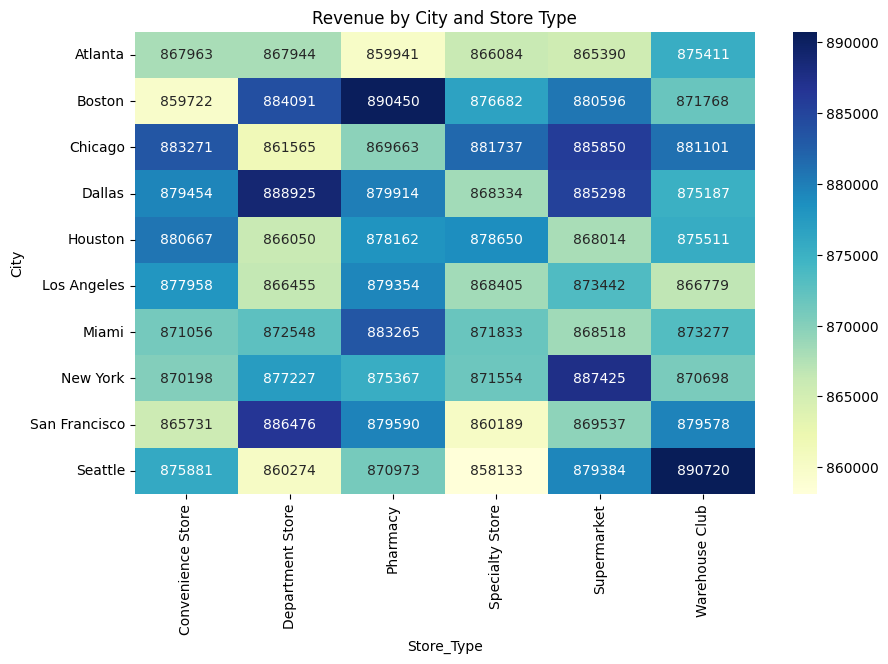

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(store_city_perf, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Revenue by City and Store Type")
plt.show()


In [ ]:
promo_impact = df.groupby(['City', 'Discount_Applied']).agg({
    'Total_Cost': 'mean',
    'Transaction_ID': 'count'
}).rename(columns={'Transaction_ID': 'Transaction_Count'}).reset_index()

promo_impact.head()


,City,Discount_Applied,Total_Cost,Transaction_Count
0,Atlanta,0,52.334868,49289
1,Atlanta,1,52.699008,49777
2,Boston,0,52.250830,50416
3,Boston,1,52.423332,50150
4,Chicago,0,52.365987,49971


| Metric                     | Formula                                    | Insight                  |
| -------------------------- | ------------------------------------------ | ------------------------ |
| **Revenue per Store**      | sum(Total_Cost)                            | Top-grossing locations   |
| **Transactions per Store** | count(Transaction_ID)                      | Traffic level            |
| **Avg Spend per Customer** | Revenue / Customers                        | Customer value           |
| **Discount Uptake Rate**   | % transactions with Discount Applied = Yes | Promotion responsiveness |
